<a href="https://colab.research.google.com/github/TorresNaly/ce-bigfish/blob/main/notebooks/train_Cellpose-SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cellpose-SAM: superhuman generalization for cellular segmentation

Marius Pachitariu, Michael Rariden, Carsen Stringer

[paper](https://www.biorxiv.org/content/10.1101/2025.04.28.651001v1) | [code](https://github.com/MouseLand/cellpose)

This notebook shows how to process your own 2D or 3D images, saved on Google Drive.

This notebook is adapted from the notebook by Pradeep Rajasekhar, inspired by the [ZeroCostDL4Mic notebook series](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki).

### Make sure you have GPU access enabled by going to Runtime -> Change Runtime Type -> Hardware accelerator and selecting GPU

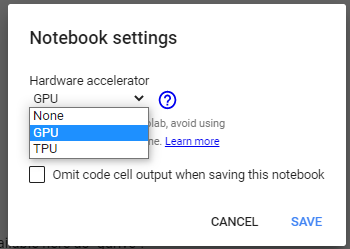

### Mount your google drive

If you have some images to train on, mount your drive. Alternatively scroll down and download the example images.

Run this cell to connect your Google Drive to colab:
* Click on the URL.
* Sign in your Google Account.

You will either have to:
* copy the authorisation code and enter it into box below OR
* in the new google colab, you can just click "Allow" and it should connect.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



Then click on "Folder" icon on the Left, press the refresh button. Your Google Drive folder should now be available here as "gdrive".


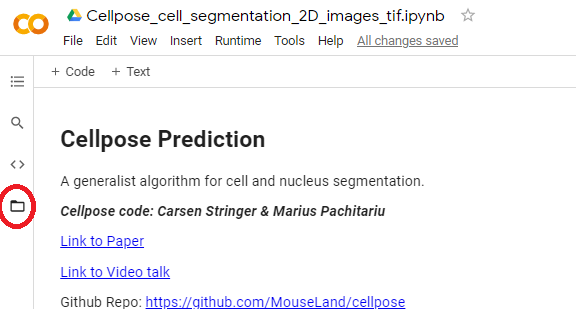

Click on the triangle icon and it will allow you to access whole drive. Navigate to the folder containing your images. Once you are there, click on the three dots on the right of the folder and select "Copy Path"

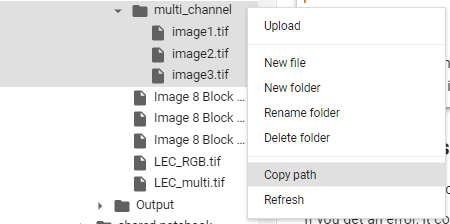

Copy and paste this path in the **dir** string below

### Install Cellpose-SAM


In [2]:
!pip install git+https://www.github.com/mouseland/cellpose.git

  Cloning https://www.github.com/mouseland/cellpose.git to /tmp/pip-req-build-smys2hqh
  Running command git clone --filter=blob:none --quiet https://www.github.com/mouseland/cellpose.git /tmp/pip-req-build-smys2hqh
  Resolved https://www.github.com/mouseland/cellpose.git to commit df6b944673c3ab6d46c2cb780bcde040970dbebc
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   

Check GPU and instantiate model - will download weights.

In [3]:
import numpy as np
from cellpose import models, core, io, plot
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt

io.logger_setup() # run this to get printing of progress

#Check if colab notebook instance has GPU access
if core.use_gpu()==False:
  raise ImportError("No GPU access, change your runtime")

model = models.CellposeModel(gpu=True)



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.7.dev7+gdf6b944 
platform:       	linux 
python version: 	3.11.13 
torch version:  	2.6.0+cu124! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 


creating new log file
2025-07-23 21:19:36,774 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2025-07-23 21:19:36,775 [INFO] 
cellpose version: 	4.0.7.dev7+gdf6b944 
platform:       	linux 
python version: 	3.11.13 
torch version:  	2.6.0+cu124
2025-07-23 21:19:37,060 [INFO] ** TORCH CUDA version installed and working. **
2025-07-23 21:19:37,062 [INFO] ** TORCH CUDA version installed and working. **
2025-07-23 21:19:37,063 [INFO] >>>> using GPU (CUDA)
2025-07-23 21:19:39,907 [INFO] Downloading: "https://huggingface.co/mouseland/cellpose-sam/resolve/main/cpsam" to /root/.cellpose/models/cpsam



100%|██████████| 1.15G/1.15G [00:06<00:00, 187MB/s]


Input directory with your images (if you have them, otherwise use sample images):

In [45]:
# *** change to your google drive folder path ***
train_dir = "/content/drive/MyDrive/cellpose_training/train_dir"
if not Path(train_dir).exists():
  raise FileNotFoundError("directory does not exist")

test_dir = "/content/drive/MyDrive/cellpose_training/test_dir" # optionally you can specify a directory with test files

# *** change to your mask extension ***
masks_ext = "_masks.tif"
# ^ assumes images from Cellpose GUI, if labels are tiffs, then "_masks.tif"

# list all files
files = [f for f in Path(test_dir).glob("*") if "_masks" not in f.name and "_flows" not in f.name and "_seg" not in f.name]

if(len(files)==0):
  raise FileNotFoundError("no files found, did you specify the correct folder and extension?")
else:
  print(f"{len(files)} files in folder:")

for f in files:
  print(f.name)


6 files in folder:
img_1.tif
img_19.tif
img_2.tif
img_29.tif
img_9.tif
img_8.tif


In [46]:
import tifffile
import numpy as np

for f in files:
    img = tifffile.imread(f)
    print(f"{f.name}: shape = {img.shape}")

img_1.tif: shape = (1024, 1024)
img_19.tif: shape = (1024, 1024)
img_2.tif: shape = (1024, 1024)
img_29.tif: shape = (1024, 1024)
img_9.tif: shape = (1024, 1024)
img_8.tif: shape = (1024, 1024)


In [41]:
from pathlib import Path
import tifffile
import numpy as np

input_dir = Path("/content/drive/MyDrive/cellpose_training/test_dir")
for f in input_dir.glob("img_*.tif"):
    img = tifffile.imread(f)
    if img.shape[0] == 1:
        img = img[0]  # remove channel axis
    tifffile.imwrite(f, img.astype(np.float32))  # overwrite or save to new dir


In [42]:
import tifffile
import numpy as np

for f in files:
    img = tifffile.imread(f)
    print(f"{f.name}: shape = {img.shape}")

img_1.tif: shape = (1024, 1024)
img_19.tif: shape = (1024, 1024)
img_2.tif: shape = (1024, 1024)
img_29.tif: shape = (1024, 1024)
img_9.tif: shape = (1024, 1024)
img_8.tif: shape = (1024, 1024)


In [44]:
for i, img in enumerate(train_data):
    print(f"Train {i}: shape={img.shape}, min={img.min()}, max={img.max()}")

for i, img in enumerate(test_data):
    print(f"Test {i}: shape={img.shape}, min={img.min()}, max={img.max()}")


Train 0: shape=(1024, 1024), min=138.0, max=2303.0
Train 1: shape=(1024, 1024), min=133.0, max=2689.0
Train 2: shape=(1024, 1024), min=139.0, max=1935.0
Train 3: shape=(1024, 1024), min=135.0, max=2420.0
Train 4: shape=(1024, 1024), min=143.0, max=2931.0
Train 5: shape=(1024, 1024), min=126.0, max=2365.0
Train 6: shape=(1024, 1024), min=127.0, max=2404.0
Train 7: shape=(1024, 1024), min=127.0, max=2206.0
Train 8: shape=(1024, 1024), min=130.0, max=3279.0
Test 0: shape=(1, 1024, 1024), min=140.0, max=2321.0
Test 1: shape=(1, 1024, 1024), min=134.0, max=2409.0
Test 2: shape=(1, 1024, 1024), min=130.0, max=1964.0
Test 3: shape=(1, 1024, 1024), min=133.0, max=1989.0
Test 4: shape=(1, 1024, 1024), min=142.0, max=3489.0
Test 5: shape=(1, 1024, 1024), min=125.0, max=2389.0


### Sample images (optional)

You can use our sample images instead of mounting your google drive

In [ ]:
from natsort import natsorted
from cellpose import utils
from pathlib import Path

url = "https://drive.google.com/uc?id=1HXpLczf7TPCdI1yZY5KV3EkdWzRrgvhQ"
utils.download_url_to_file(url, "human_in_the_loop.zip")

!unzip human_in_the_loop

train_dir = "human_in_the_loop/train/"
test_dir = "human_in_the_loop/test/"

masks_ext = "_seg.npy"


## Train new model

In [19]:
from cellpose import train

model_name = "2-cell_model"

# default training params
n_epochs = 100
learning_rate = 1e-5
weight_decay = 0.1
batch_size = 1

# get files
output = io.load_train_test_data(train_dir, test_dir)
train_data, train_labels, _, test_data, test_labels, _ = output
# (not passing test data into function to speed up training)

new_model_path, train_losses, test_losses = train.train_seg(model.net,
                                                            train_data=train_data,
                                                            train_labels=train_labels,
                                                            batch_size=batch_size,
                                                            n_epochs=n_epochs,
                                                            learning_rate=learning_rate,
                                                            weight_decay=weight_decay,
                                                            min_train_masks=2,
                                                            nimg_per_epoch=max(2, len(train_data)), # can change this
                                                            model_name=model_name)


2025-07-23 21:33:02,104 [INFO] not all flows are present, running flow generation for all images
2025-07-23 21:33:09,994 [INFO] 9 / 9 images in /content/drive/MyDrive/cellpose_training/train_dir folder have labels
2025-07-23 21:33:10,004 [INFO] not all flows are present, running flow generation for all images
2025-07-23 21:33:10,080 [INFO] 6 / 6 images in /content/drive/MyDrive/cellpose_training/test_dir folder have labels
2025-07-23 21:33:10,081 [INFO] computing flows for labels


100%|██████████| 9/9 [00:02<00:00,  4.39it/s]

2025-07-23 21:33:12,146 [INFO] >>> computing diameters



100%|██████████| 9/9 [00:00<00:00, 224.78it/s]

2025-07-23 21:33:12,190 [INFO] >>> normalizing {'lowhigh': None, 'percentile': None, 'normalize': True, 'norm3D': True, 'sharpen_radius': 0, 'smooth_radius': 0, 'tile_norm_blocksize': 0, 'tile_norm_smooth3D': 1, 'invert': False}


2025-07-23 21:33:12,449 [INFO] >>> n_epochs=100, n_train=9, n_test=None
2025-07-23 21:33:12,450 [INFO] >>> AdamW, learning_rate=0.00001, weight_decay=0.10000
2025-07-23 21:33:12,455 [INFO] >>> saving model to /content/models/2-cell_model
2025-07-23 21:33:21,874 [INFO] 0, train_loss=0.1982, test_loss=0.0000, LR=0.000000, time 9.42s
2025-07-23 21:34:04,813 [INFO] 5, train_loss=0.6532, test_loss=0.0000, LR=0.000006, time 52.36s
2025-07-23 21:34:48,880 [INFO] 10, train_loss=0.7774, test_loss=0.0000, LR=0.000010, time 96.43s
2025-07-23 21:36:19,696 [INFO] 20, train_loss=0.2225, test_loss=0.0000, LR=0.000010, time 187.24s
2025-07-23 21:37:51,387 [INFO] 30, train_loss=0.1086, test_loss=0.0000, LR=0.000010, time 278.93s
2025-07-23 21:39:23,137 [INFO] 40, train_loss=0.1316, test_loss=0.0000, LR=0.000010, time 370.68s
2025-07-23 21:40:55,046 [INFO] 50, train_loss=0.0569, test_loss=0.0000, LR=0.000005, time 462.59s
2025-07-23 21:42:26,818 [INFO] 60, train_loss=0.0507, test_loss=0.0000, LR=0.00000

## Evaluate on test data (optional)

If you have test data, check performance

In [38]:
img = test_data[0]
print(f"Shape: {img.shape}, dtype: {img.dtype}, min: {img.min()}, max: {img.max()}")


Shape: (1, 1024, 1024), dtype: float32, min: 140.0, max: 2321.0


In [43]:
for i, img in enumerate(train_data):
    print(f"Train {i}: shape={img.shape}, min={img.min()}, max={img.max()}")

for i, img in enumerate(test_data):
    print(f"Test {i}: shape={img.shape}, min={img.min()}, max={img.max()}")


Train 0: shape=(1024, 1024), min=138.0, max=2303.0
Train 1: shape=(1024, 1024), min=133.0, max=2689.0
Train 2: shape=(1024, 1024), min=139.0, max=1935.0
Train 3: shape=(1024, 1024), min=135.0, max=2420.0
Train 4: shape=(1024, 1024), min=143.0, max=2931.0
Train 5: shape=(1024, 1024), min=126.0, max=2365.0
Train 6: shape=(1024, 1024), min=127.0, max=2404.0
Train 7: shape=(1024, 1024), min=127.0, max=2206.0
Train 8: shape=(1024, 1024), min=130.0, max=3279.0
Test 0: shape=(1, 1024, 1024), min=140.0, max=2321.0
Test 1: shape=(1, 1024, 1024), min=134.0, max=2409.0
Test 2: shape=(1, 1024, 1024), min=130.0, max=1964.0
Test 3: shape=(1, 1024, 1024), min=133.0, max=1989.0
Test 4: shape=(1, 1024, 1024), min=142.0, max=3489.0
Test 5: shape=(1, 1024, 1024), min=125.0, max=2389.0


In [34]:
from cellpose import metrics

model = models.CellposeModel(gpu=True,
                             pretrained_model=new_model_path)

# run model on test images
masks = model.eval(test_data, batch_size=32)[0]

# check performance using ground truth labels
ap = metrics.average_precision(test_labels, masks)[0]
print('')
print(f'>>> average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')


2025-07-23 21:53:33,543 [INFO] ** TORCH CUDA version installed and working. **
2025-07-23 21:53:33,544 [INFO] >>>> using GPU (CUDA)
2025-07-23 21:53:36,146 [INFO] >>>> loading model /content/models/2-cell_model
2025-07-23 21:53:36,544 [INFO] 0%|          | 0/6 [00:00<?, ?it/s]
2025-07-23 21:53:44,555 [INFO] No cell pixels found.
2025-07-23 21:53:52,726 [INFO] No cell pixels found.
2025-07-23 21:54:01,020 [INFO] No cell pixels found.
2025-07-23 21:54:09,388 [INFO] No cell pixels found.
2025-07-23 21:54:09,463 [INFO] 67%|######6   | 4/6 [00:32<00:16,  8.23s/it]
2025-07-23 21:54:18,017 [INFO] No cell pixels found.
2025-07-23 21:54:20,180 [INFO] 67%|######6   | 4/6 [00:43<00:16,  8.23s/it]
2025-07-23 21:54:27,099 [INFO] No cell pixels found.
2025-07-23 21:54:27,166 [INFO] 100%|##########| 6/6 [00:50<00:00,  8.44s/it]

>>> average precision at iou threshold 0.5 = 0.000


plot masks

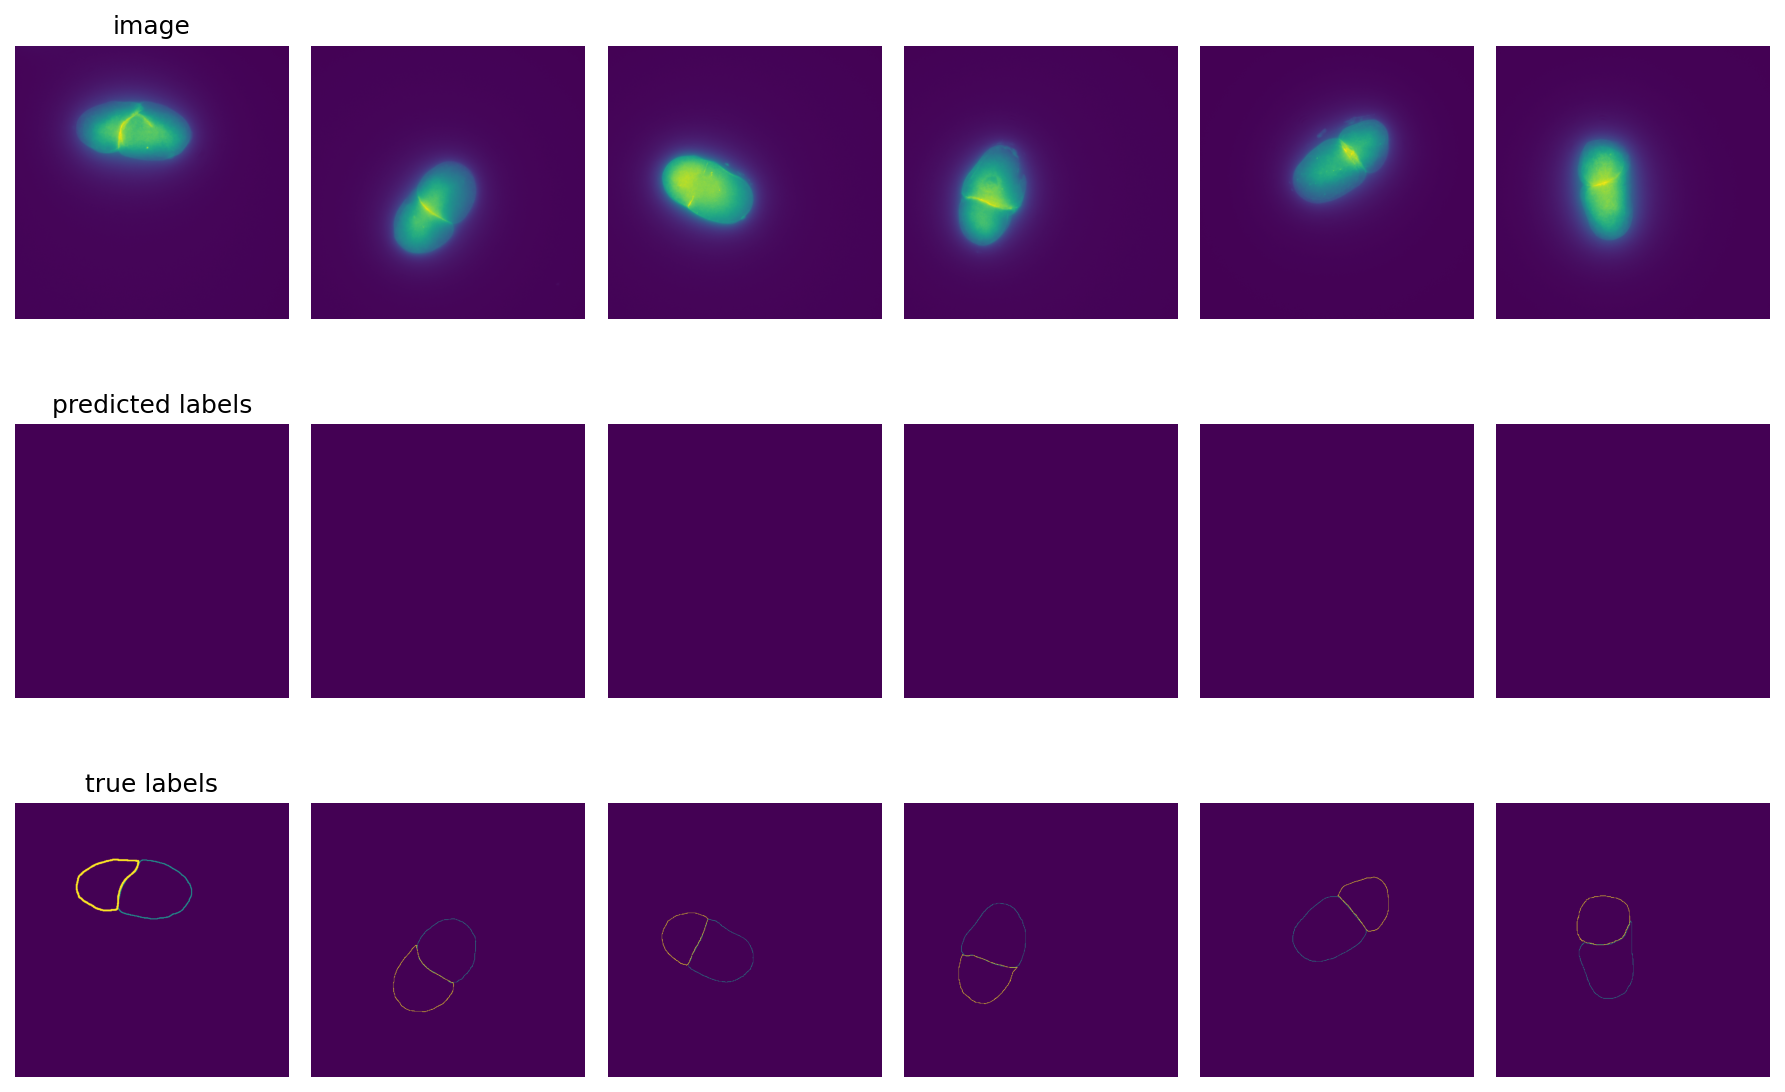

In [37]:
plt.figure(figsize=(12,8), dpi=150)
for k,im in enumerate(test_data):
    img = im.copy()
    plt.subplot(3,len(test_data), k+1)
    img = np.vstack((img, np.zeros_like(img)[:0]))
    img = img.transpose(1,2,0)
    plt.imshow(img)
    plt.axis('off')
    if k==0:
        plt.title('image')

    plt.subplot(3,len(test_data), len(test_data) + k+1)
    plt.imshow(masks[k])
    plt.axis('off')
    if k==0:
        plt.title('predicted labels')

    plt.subplot(3,len(test_data), 2*len(test_data) + k+1)
    plt.imshow(test_labels[k])
    plt.axis('off')
    if k==0:
        plt.title('true labels')
plt.tight_layout()